## solving schrodnger equation

In [301]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot
import json
%matplotlib widget

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Left2"]
# FT_Device = params["UMA5"]
# FT_Device = params["FT_NICK"]
# FT_Device = params["FTF_FUN10_Type_3"]
# FT_Device = params["FT_FUN14_long2"]

k = 120
trunc = 7

Fl1 = scq.Fluxonium(
    EJ=FT_Device['fluxonium']['EJ'],
    EC=FT_Device['fluxonium']['EC'],
    EL=FT_Device['fluxonium']['EL'],
    flux=0.5,
    cutoff=k,
    truncated_dim=trunc
)
Tr = scq.Transmon(
    EJ=FT_Device['transmon']['EJ'],
    EC=FT_Device['transmon']['EC'],
    ng=0,
    ncut=k,
    truncated_dim=trunc
)

J1T = FT_Device['Jc']

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(
    g=J1T,
    op1=(Fl1.n_operator(), Fl1),
    op2=(Tr.n_operator(), Tr)
)
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])
phi_Fl1_full = scq.identity_wrap(Fl1.phi_operator(), Fl1, [Fl1, Tr])

def get_dressed_epairs(evals, ekets):
    dressed_epairs = np.empty((6, 6), dtype=object)
    for i in range(6):
        for j in range(6):
            index = full_system.dressed_index((i, j))
            bare_ket = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j))
            if index is None:
                # Manually find dressed state with max overlap
                overlaps = [abs(bare_ket.overlap(eket))**2 for eket in ekets]
                index = np.argmax(overlaps)
                fidelity = overlaps[index]
                if fidelity < 0.5:  # Arbitrary threshold; adjust as needed
                    print(f"Warning: Low fidelity {fidelity:.3f} for bare state |{i}{j}>")
            ztemp = bare_ket.overlap(ekets[index])
            dressed_epairs[i, j] = (evals[index], np.exp(-1j * np.angle(ztemp)) * ekets[index])
    return dressed_epairs

dressed_epairs = get_dressed_epairs(evals, ekets)

evalues = (H_full.eigenenergies() - H_full.eigenenergies()[0]) / 6.28

e_11 = evalues[full_system.dressed_index((1,1))]
e_10 = evalues[full_system.dressed_index((1,0))]
e_01 = evalues[full_system.dressed_index((0,1))]
e_00 = evalues[full_system.dressed_index((0,0))]
e_20 = evalues[full_system.dressed_index((2,0))]
e_30 = evalues[full_system.dressed_index((3,0))]
e_40 = evalues[full_system.dressed_index((4,0))]
e_21 = evalues[full_system.dressed_index((2,1))]


print('Static_ZZ(MHz)= ',(e_11-e_10-e_01+e_00)*1e3)
print('dressed_F_01(GHz)= ',(e_10-e_00)*1)
print('dressed_F_12(GHz)= ',(e_20-e_10)*1)
print('dressed_F_03(GHz)= ',(e_30-e_00)*1)
print('dressed_T_01(GHz)= ',(e_01-e_00)*1)
print('dressed_F_04(GHz)= ',(e_40-e_00)*1)







Static_ZZ(MHz)=  0.7651047008900846
dressed_F_01(GHz)=  0.1701107361048761
dressed_F_12(GHz)=  3.5118627375951132
dressed_F_03(GHz)=  5.080943844905588
dressed_T_01(GHz)=  3.807487448758071
dressed_F_04(GHz)=  7.620047862761177


In [292]:
nF_00_01   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
print('nF_00_01 = ', nF_00_01)
n_Fl1_full

nF_00_01 =  (0.005282640076302744+6.487705459820221e-16j)


Quantum object: dims=[[7, 7], [7, 7]], shape=(49, 49), type='oper', dtype=Dense, isherm=True
Qobj data =
[[0.-1.68002363e-31j 0.+0.00000000e+00j 0.+0.00000000e+00j ...
  0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.-1.68002363e-31j 0.+0.00000000e+00j ...
  0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.-1.68002363e-31j ...
  0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j]
 ...
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j ...
  0.+6.19882071e-31j 0.+0.00000000e+00j 0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j ...
  0.+0.00000000e+00j 0.+6.19882071e-31j 0.+0.00000000e+00j]
 [0.+0.00000000e+00j 0.+0.00000000e+00j 0.+0.00000000e+00j ...
  0.+0.00000000e+00j 0.+0.00000000e+00j 0.+6.19882071e-31j]]

In [302]:
def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct


def time_dep(t, args):
    w_d = args['w_d']
    return 2 *3.14* np.cos(w_d*t) * envelop_function(t, args['t_g'], args['t_r'])

crosstalk = FT_Device.get("crosstalk", {"Cg_F":0, "Cg_FT":0, "Cg_T":0})
Cg_F = crosstalk["Cg_F"]
Cg_FT = crosstalk["Cg_FT"]
Cg_T = crosstalk["Cg_T"]
Csum_F = (1.602176634e-19**2)/(2*6.62607015e-34*FT_Device['fluxonium']['EC']*1e9)
Csum_T = (1.602176634e-19**2)/(2*6.62607015e-34*FT_Device['transmon']['EC']*1e9)

EF = Cg_F / Csum_F * 1e-15
EFT = Cg_FT / Csum_F * 1e-15
ET = Cg_T / Csum_T * 1e-15
print(f'EF, EFT, ET = {EF:.5f}, {EFT:.5f}, {ET:.5f}')



nF_00_01   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nF_10_11   = (n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]))
nT_00_01   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))

print(f'nF_10_11 = {nF_10_11:.5f}')
print(f'nF_00_01 = {nF_00_01:.5f}')
print(f'nT = {nT_00_01:.5f}')

t_r = 10
t_g = 2000
t_list = np.linspace(0, t_g, 1000)
alpha =32.5
w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta = np.real(eta(EF, EFT, ET, nF_00_01, nT_00_01)) # means no selective darkening
print(f'eta = {eta:.4f}')

crosstalk_ratio = EFT/EF *100
print(f'crosstalk_ratio(%) = {crosstalk_ratio:.2f}')


EF, EFT, ET = 0.00566, 0.00052, 0.00176
nF_10_11 = -0.02461-0.00000j
nF_00_01 = 0.00528+0.00000j
nT = -1.06395-0.00000j
eta = -0.2795
crosstalk_ratio(%) = 9.17


In [269]:
2*3.44 -  w_d/6.28 
 

np.float64(3.0717474465410546)

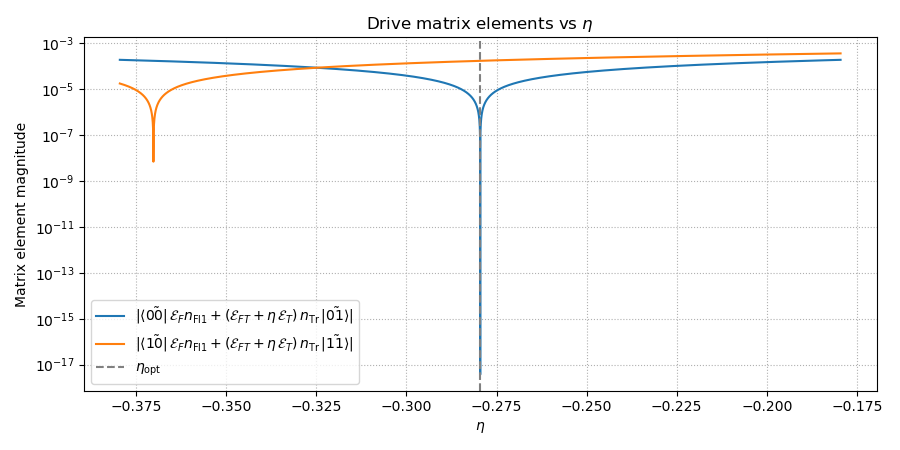

In [303]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# --- sweep around your chosen center (opteta_p must be defined)
eta_values = np.linspace(eta - .1, eta + .1, 15001)

# --- dressed computational kets
e1 = dressed_epairs[0, 0][1]  # |~00>
e2 = dressed_epairs[0, 1][1]  # |~01>
e3 = dressed_epairs[1, 0][1]  # |~10>
e4 = dressed_epairs[1, 1][1]  # |~11>

# --- precompute the eta-independent part of the operator:
#     O(eta) = EF * n_Fl1_full + (EFT + ET*eta) * n_Tr_full
#            = (EF * n_Fl1_full + EFT * n_Tr_full) + (ET * eta) * n_Tr_full
O_base = EF * n_Fl1_full + EFT * n_Tr_full
O_tr   = ET * n_Tr_full  # this multiplies eta_p each step

# --- compute matrix elements for each eta_p
matrix_elements_00_01 = [
    (O_base + eta_p * O_tr).matrix_element(e1, e2) for eta_p in eta_values
]
matrix_elements_10_11 = [
    (O_base + eta_p * O_tr).matrix_element(e3, e4) for eta_p in eta_values
]

# --- magnitudes (you can also keep phases if you want)
magnitudes_00_01 = np.abs(matrix_elements_00_01)
magnitudes_10_11 = np.abs(matrix_elements_10_11)

# --- plotting
plt.figure(figsize=(9, 4.5))
plt.semilogy(
    eta_values, magnitudes_00_01,
    label=(r'$|\langle \tilde{00} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{01}\rangle|$')
)
plt.semilogy(
    eta_values, magnitudes_10_11,
    label=(r'$|\langle \tilde{10} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{11}\rangle|$')
)

plt.axvline(eta, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.title('Drive matrix elements vs $\eta$')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


nF_10_11 =  (-0.004455693904198787-4.8044178201410645e-17j)
nF_00_01 =  (0.003386424015094655-3.2663350289578784e-16j)
nT =  (-1.332051235986898+1.991910524110701e-19j)
eta =  -0.9791670390116046


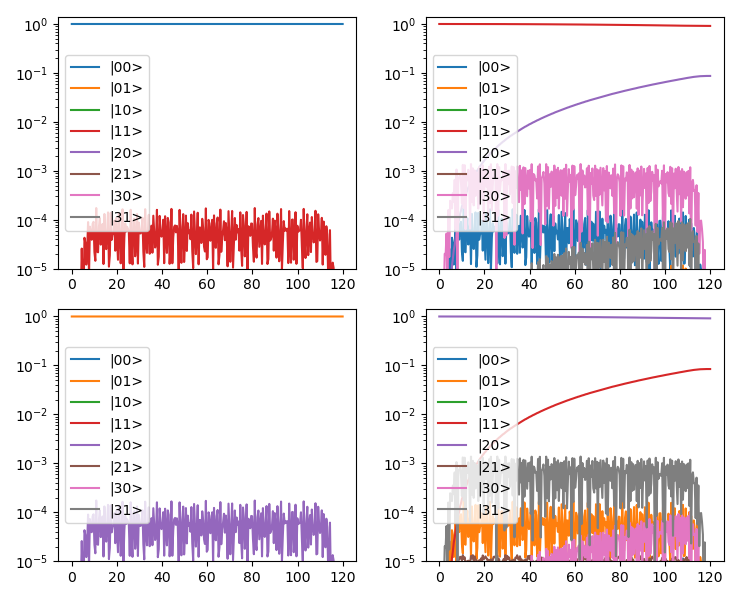

In [282]:
#trying to get the time evolution with different envelopes

def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct


def time_dep(t, args):
    w_d = args['w_d']
    w_d_mirror = 6.28*(2*3.44 -  w_d/6.28) #mirrored frequency
    return 2 *3.14* (np.cos(w_d*t) +  np.cos(w_d_mirror*t)) * envelop_function(t, args['t_g'], args['t_r'])



nF_00_01   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nF_10_11   = (n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]))
nT_00_01   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))

print('nF_10_11 = ', nF_10_11)
print('nF_00_01 = ', nF_00_01)
print('nT = ', nT_00_01)

t_r = 10
t_g = 120
t_list = np.linspace(0, t_g, 300)
alpha =12.5*2

w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta = np.real(eta(EF, EFT, ET, nF_00_01, nT_00_01)) # means no selective darkening
print('eta = ', eta)

H_tot = [H_full, [alpha * (EF * n_Fl1_full + EFT * n_Tr_full + eta * ET * n_Tr_full), time_dep]]


def prob_lists(psi):
    p_lists = [[] for _ in range(8)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(8):
            idx1 = i // 3
            idx2 = i % 3
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 0 for p in p_list):
                label = "|" + str(j // 2) + str(j % 2) + ">"
                axs[i].semilogy(t_list, p_list, label=label)
                # axs[i].plot(t_list, p_list, label=label)

        axs[i].set_ylim(1e-5, 1.4)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

nF_10_11 =  (-0.02461247995016142-2.5317608544563952e-17j)
nF_00_01 =  (0.005282640076302744+6.487705459820221e-16j)
nT =  (-1.0639494419714703-8.741325317921488e-20j)
eta =  -0.2795245527787492


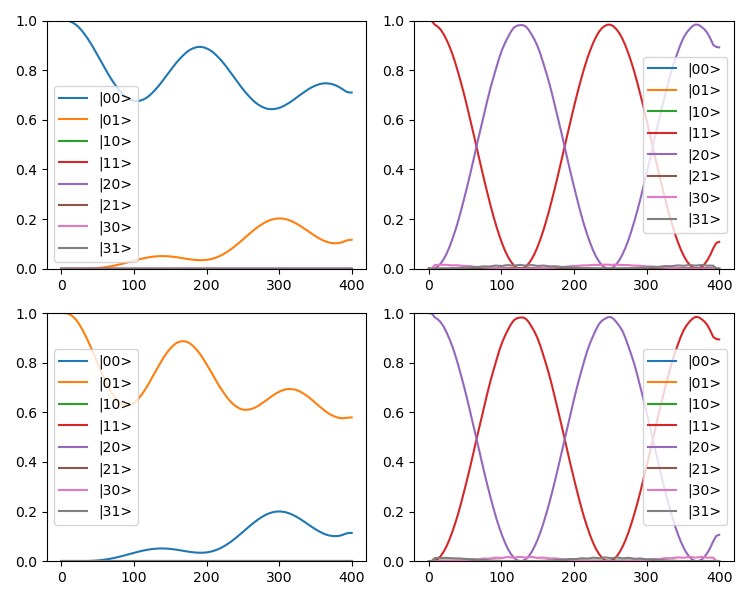

In [299]:
#trying to get the time evolution with different envelopes

def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct


def time_dep(t, args):
    w_d = args['w_d']
    w_d_mirror = 6.28*(2*3.44 -  w_d/6.28) #mirrored frequency
    return 2 *3.14* (np.cos(w_d*t) +  0* np.cos(w_d_mirror*t)) * envelop_function(t, args['t_g'], args['t_r'])



nF_00_01   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nF_10_11   = (n_Fl1_full.matrix_element(dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]))
nT_00_01   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))

print('nF_10_11 = ', nF_10_11)
print('nF_00_01 = ', nF_00_01)
print('nT = ', nT_00_01)

t_r = 10
t_g = 400
t_list = np.linspace(0, t_g, 100)
alpha =12.5*2

w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta = np.real(eta(EF, EFT, ET, nF_00_01, nT_00_01)) # means no selective darkening
print('eta = ', eta)

H_tot = [H_full, [alpha * (EF * n_Fl1_full + EFT * n_Tr_full + eta * ET * n_Tr_full), time_dep]]


def prob_lists(psi):
    p_lists = [[] for _ in range(8)]
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(8):
            idx1 = i // 3
            idx2 = i % 3
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # Create 2x2 subplots
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot only curves with values above 1e-3
        for j, p_list in enumerate(p_lists):
            if any(p > 0 for p in p_list):
                label = "|" + str(j // 2) + str(j % 2) + ">"
                # axs[i].semilogy(t_list, p_list, label=label)
                axs[i].plot(t_list, p_list, label=label)

        axs[i].set_ylim(0, 1)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

In [ ]:
def prob_lists(psi):
    # Track 16 states
    p_lists = [[] for _ in range(16)]  # For 16 states
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(16):  # Loop over all 16 states
            idx1 = i // 4  # Determine the first index for the state
            idx2 = i % 4   # Determine the second index for the state
            p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # 2x2 subplots for the 4 initial states
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot all 16 states' evolution, but focus on each initial state
        for j, p_list in enumerate(p_lists):
            if any(p > 0 for p in p_list):  # Plot only curves with values above 1e-3
                label = "|" + str(j // 4) + str(j % 4) + ">"
                # axs[i].semilogy(t_list, p_list, label=label)
                axs[i].plot(t_list, p_list, label=label)

        axs[i].set_ylim(1e-5, 1)
        axs[i].legend()
        axs[i].set_facecolor('white')

    plt.tight_layout()
    plt.show()
temp_opt_freq_gen(H_tot, args)

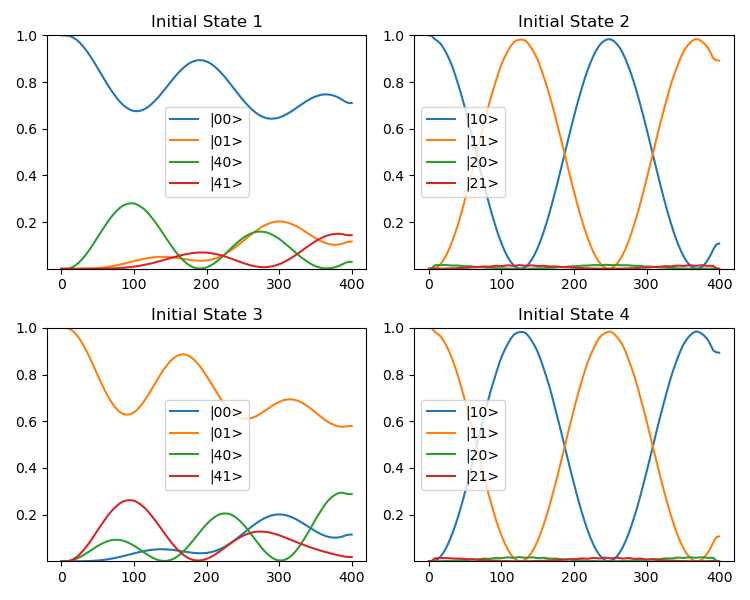

In [300]:
def prob_lists(psi):
    # Track 25 states (5x5)
    p_lists = [[] for _ in range(25)]  # For 25 states
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(25):  # Loop over all 25 states
            idx1 = i // 5  # Determine the first index for the state (rows)
            idx2 = i % 5   # Determine the second index for the state (columns)

            # Check if dressed_epairs[idx1, idx2] is valid
            if dressed_epairs[idx1, idx2] is not None:
                p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
            else:
                # Handle the case where the state is invalid or None
                print(f"Warning: dressed_epairs[{idx1}, {idx2}] is None")
                p_lists[i].append(0)  # Append 0 if the state is invalid
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # 2x2 subplots for the 4 initial states
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot all 25 states' evolution in each subplot
        for j, p_list in enumerate(p_lists):
            row = j // 5
            col = j % 5
            if any(p > .01 for p in p_list):  # Plot only curves with values above 1e-3
                label = "|" + str(row) + str(col) + ">"
                axs[i].plot(t_list, p_list, label=label)

        axs[i].set_ylim(1e-5, 1)
        axs[i].legend()
        axs[i].set_facecolor('white')
        axs[i].set_title(f"Initial State {i+1}")

    plt.tight_layout()
    plt.show()

# Call the function
temp_opt_freq_gen(H_tot, args)


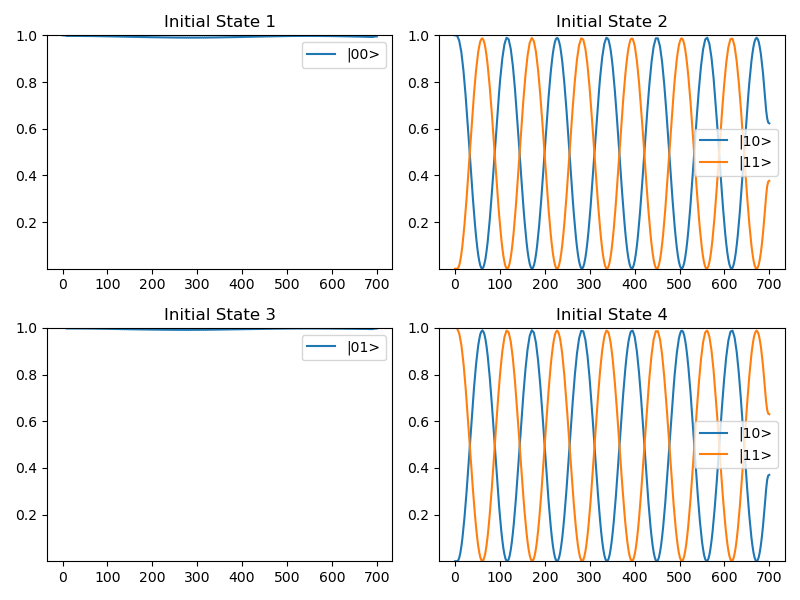

In [254]:
def prob_lists(psi):
    # Track 36 states (6x6)
    p_lists = [[] for _ in range(36)]  # For 36 states
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(36):  # Loop over all 36 states
            idx1 = i // 6  # Determine the first index for the state (rows)
            idx2 = i % 6   # Determine the second index for the state (columns)

            # Check if dressed_epairs[idx1, idx2] is valid
            if dressed_epairs[idx1, idx2] is not None:
                p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
            else:
                # Handle the case where the state is invalid or None
                print(f"Warning: dressed_epairs[{idx1}, {idx2}] is None")
                p_lists[i].append(0)  # Append 0 if the state is invalid
    return p_lists

def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(8, 6))  # 2x2 subplots for the 4 initial states
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot all 36 states' evolution in each subplot
        for j, p_list in enumerate(p_lists):
            row = j // 6  # Determine the row in the 6x6 grid
            col = j % 6   # Determine the column in the 6x6 grid
            if any(p > 0.05 for p in p_list):  # Plot only curves with values above 1e-3
                label = "|" + str(row) + str(col) + ">"
                axs[i].plot(t_list, p_list, label=label)

        axs[i].set_ylim(1e-5, 1)
        axs[i].legend()
        axs[i].set_facecolor('white')
        axs[i].set_title(f"Initial State {i+1}")

    plt.tight_layout()
    plt.show()

# Call the function
temp_opt_freq_gen(H_tot, args)


In [ ]:
print(r'|⟨00̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |01̃⟩|', ' = ', np.abs(alpha*(EF * nF_00_01 + (EFT + eta * ET) * nT_00_01)))
print(r'|⟨10̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |11̃⟩|', ' = ', np.abs(alpha*(EF * nF_10_11 + (EFT + eta * ET) * nT_00_01)))

|⟨00̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |01̃⟩|  =  1.049388758154176e-16
|⟨10̃| ε_F n_{Fl1} + (ε_{FT} + η ε_T) n_{Tr} |11̃⟩|  =  0.004234596765496849


In [304]:
U_ideal = 0 # Identity operator in the computational subspace
U_ideal += dressed_epairs[0, 0][1] * dressed_epairs[0, 0][1].dag()
U_ideal += dressed_epairs[0, 1][1] * dressed_epairs[0, 1][1].dag()
U_ideal += dressed_epairs[1, 1][1] * dressed_epairs[1, 0][1].dag()
U_ideal += dressed_epairs[1, 0][1] * dressed_epairs[1, 1][1].dag()

def U_full2comp(U_f):
    U4x4 = 1j*np.zeros([4,4])
    for dx in range(2):
        for jx in range(2):
            for kx in range(2):
                for lx in range(2):
                    U4x4[2*dx+jx,2*kx+lx] = U_f.matrix_element(dressed_epairs[dx,jx][1],dressed_epairs[kx,lx][1])
    return qt.Qobj(U4x4)

idcomp = qt.Qobj(cnot().full())

def envelop_function(t, tg, t_r):
    if t < t_r:
        fnct = np.sin(np.pi * t / 2 / t_r) ** 2
    elif t < tg - t_r:
        fnct = 1.
    else:
        fnct = np.sin(np.pi * (tg - t) / 2 / t_r) ** 2
    return fnct

def time_dep(t, args):
    w_d = args['w_d']
    return 2 * np.cos(w_d*t) * envelop_function(t,args['t_g'], args['t_r'])

# needed functions
def evolution_psi_microwave(H_tot, psi0, t_points, args):
    result = qt.sesolve(H_tot, psi0, t_points, args=args, options=qt.Options(nsteps=25000))
    return result.states

def evolution_subspace(H_tot, args, subspace_states, t_points):
    psi_t = []
    for ind, psi_0 in enumerate(subspace_states):
        temp = evolution_psi_microwave(H_tot, psi_0, t_points=t_points, args=args)
        psi_t.append(temp)

    U_t = np.empty_like(t_points, dtype=object)
    ind_t = len(t_points) - 1
    U = 0
    for ind, psi_0 in enumerate(subspace_states):
        U += psi_t[ind][ind_t] * psi_0.dag()
    U_t[ind_t] = U
    return U_t

def gate(H_tot, args):
    comp_space = [dressed_epairs[0, 0][1], dressed_epairs[0, 1][1], dressed_epairs[1, 0][1], dressed_epairs[1, 1][1]]
    U_t = evolution_subspace(H_tot, args, comp_space, t_list)
    U_act = U_t[-1]
    return U_act

def abs_fidelity_CX1(params, t_g, t_r):
    alpha, eta, detuning = params
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (n_Fl1_full + eta * n_Tr_full), time_dep]]
    
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    
    U_act = qt.Qobj(np.abs(U_full2comp(gate(H_tot, args)).full()))

    op1 = U_act.dag() * U_act
    op2 = idcomp.dag() * U_act
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 20.0
    return -fidelity

def abs_fidelity_CX1_with_crosstalk(params, t_g, t_r, EF, EFT, ET): 
    
    alpha, eta_p, detuning = params
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    H_tot = [H_full, [alpha * (EF * n_Fl1_full +(EFT + ET * eta_p) * n_Tr_full), time_dep]]
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    U_act = qt.Qobj(np.abs(U_full2comp(gate(H_tot, args)).full()))
    op1 = U_act.dag() * U_act
    op2 = idcomp.dag() * U_act
    fidelity = (op1.tr() + (abs(op2.tr()))**2) / 20.0
    return -fidelity

def eta(EF, EFT, ET, nF, nT):
    """
       Compute eta from the drive cancellation equation:
       eta = - ( EF*nF + EFT*nT ) / ( ET*nT )
    """
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator



In [318]:
nF   = (n_Fl1_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
nT   = (n_Tr_full.matrix_element(dressed_epairs[0, 0][1], dressed_epairs[0, 1][1]))
# EF = .22/22.5 # keeping the same as FUN5
# EFT  = 0.02* EF
# ET   = .06/117.5 # keeping it similar to UMA5

def eta(EF, EFT, ET, nF, nT):
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator

eta_p = eta(EF, EFT, ET, nF, nT)
alpha = 60
detuning = 0.9999
t_g = 250
t_r = 10
t_list = np.linspace(0, t_g, 1000)

initial_guess = [alpha, eta_p, detuning]


result = opt.minimize(abs_fidelity_CX1_with_crosstalk, initial_guess, args=(t_g, t_r, EF, EFT, ET), method='Nelder-Mead', options={'fatol': 0.00001, 'xatol': 0.00001})
optalpha, opteta_p, optdetuning = result.x

w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*optdetuning
H_tot = [H_full, [optalpha * (EF * n_Fl1_full + (EFT + ET * opteta_p) * n_Tr_full), time_dep]]

args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

U_act = np.abs(U_full2comp(gate(H_tot, args)).full())

max_fidelity = -result.fun

a = 1 - U_act[0,0]
b = 1 - U_act[1,1]
c = 1 - U_act[2,3]
d = 1 - U_act[3,2]

dark = 2*(a + b)/5
flip = 2*(c + d)/5

bright = 2/5 * abs(U_act[0,1])

leak = abs(1 - np.trace(np.transpose(U_act)@U_act)/4)


print(f"dark = {dark:.3e}, flip = {flip:.3e}, leak = {leak:.3e}, max_fidelity = {max_fidelity:.6f}")

opt_names = ("optalpha", "opteta_p", "optdetuning")
opt_vals = result.x
print("Optimized parameters:")
for name, val in zip(opt_names, opt_vals):
    print(f"  {name:>12s} = {val:.6g}")

print(f"Optimizer success: {result.success}, nit: {getattr(result, 'nit', 'N/A')}, message: {result.message}")


dark = 2.653e-03, flip = 8.354e-05, leak = 3.267e-03, max_fidelity = 0.996613
Optimized parameters:
      optalpha = 36.9959+0j
      opteta_p = -0.275548+1.93794e-15j
   optdetuning = 0.999999+0j
Optimizer success: True, nit: 98, message: Optimization terminated successfully.


 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/matplotlib/cbook.py: 1719ComplexWarning: Casting complex values to real discards the imaginary part
 /opt/homebrew/Caskroom/miniconda/base/envs/scqubits_copy/lib/python3.12/site-packages/matplotlib/cbook.py: 1355

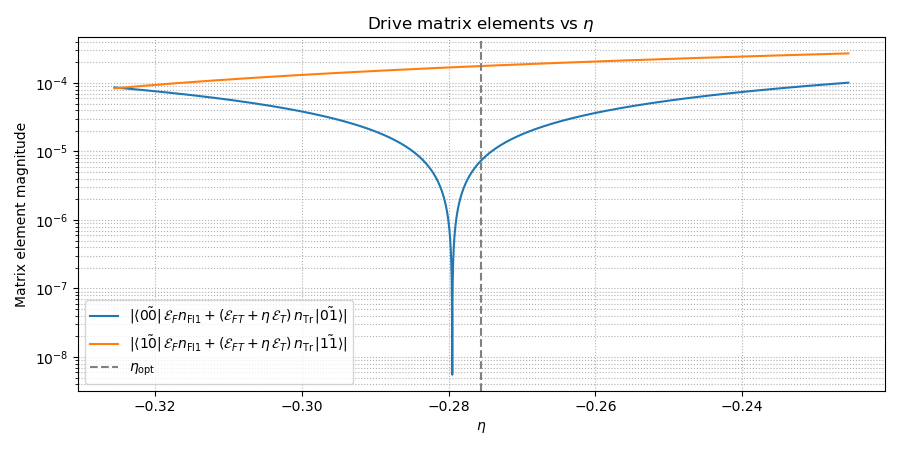

In [319]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
# --- sweep around your chosen center (opteta_p must be defined)
eta_values = np.linspace(opteta_p - .05, opteta_p + .05, 15001)

# --- dressed computational kets
e1 = dressed_epairs[0, 0][1]  # |~00>
e2 = dressed_epairs[0, 1][1]  # |~01>
e3 = dressed_epairs[1, 0][1]  # |~10>
e4 = dressed_epairs[1, 1][1]  # |~11>

# --- precompute the eta-independent part of the operator:
#     O(eta) = EF * n_Fl1_full + (EFT + ET*eta) * n_Tr_full
#            = (EF * n_Fl1_full + EFT * n_Tr_full) + (ET * eta) * n_Tr_full
O_base = EF * n_Fl1_full + EFT * n_Tr_full
O_tr   = ET * n_Tr_full  # this multiplies eta_p each step

# --- compute matrix elements for each eta_p
matrix_elements_00_01 = [
    (O_base + eta_p * O_tr).matrix_element(e1, e2) for eta_p in eta_values
]
matrix_elements_10_11 = [
    (O_base + eta_p * O_tr).matrix_element(e3, e4) for eta_p in eta_values
]

# --- magnitudes (you can also keep phases if you want)
magnitudes_00_01 = np.abs(matrix_elements_00_01)
magnitudes_10_11 = np.abs(matrix_elements_10_11)

# --- plotting
plt.figure(figsize=(9, 4.5))
plt.semilogy(
    eta_values, magnitudes_00_01,
    label=(r'$|\langle \tilde{00} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{01}\rangle|$')
)
plt.semilogy(
    eta_values, magnitudes_10_11,
    label=(r'$|\langle \tilde{10} |\, \mathcal{E}_F n_{\mathrm{Fl1}}'
           r'+(\mathcal{E}_{FT}+\eta\,\mathcal{E}_T)\,n_{\mathrm{Tr}} \,| \tilde{11}\rangle|$')
)

plt.axvline(opteta_p, color='gray', linestyle='--', label=r'$\eta_{\mathrm{opt}}$')
plt.xlabel(r'$\eta$')
plt.ylabel('Matrix element magnitude')
plt.title('Drive matrix elements vs $\eta$')
plt.legend()
plt.grid(True, which='both', ls=':')
plt.tight_layout()
plt.show()


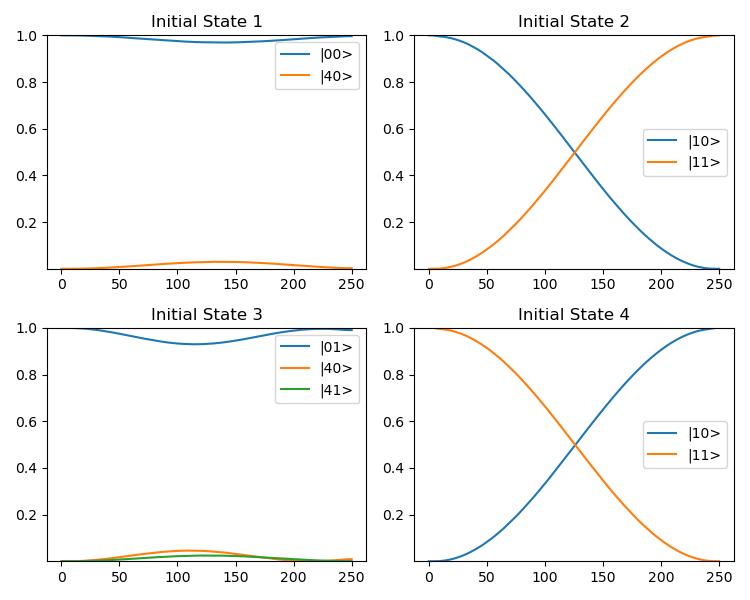

In [320]:

check = False
if check:
    alpha = optalpha
    eta_p = opteta_p
    detuning = optdetuning
    t_g = 1000
    t_r = 10
    t_list = np.linspace(0, t_g, 1000)
    w_d = (dressed_epairs[1, 1][0] - dressed_epairs[1, 0][0])*detuning
    args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}
    H_tot = [H_full, [alpha * (EF * n_Fl1_full + (EFT + ET * eta_p) * n_Tr_full), time_dep]]
else:
    H_tot = [H_full, [optalpha * (EF * n_Fl1_full + (EFT + ET * opteta_p) * n_Tr_full), time_dep]]


# def prob_lists(psi):
#     p_lists = [[] for _ in range(9)]
#     for ndx in range(len(psi)):
#         psi_t = psi[ndx]
#         for i in range(8):
#             idx1 = i // 3
#             idx2 = i % 3
#             p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
#     return p_lists


def prob_lists(psi):
    # Track 25 states (5x5)
    p_lists = [[] for _ in range(25)]  # For 25 states
    for ndx in range(len(psi)):
        psi_t = psi[ndx]
        for i in range(25):  # Loop over all 25 states
            idx1 = i // 5  # Determine the first index for the state (rows)
            idx2 = i % 5   # Determine the second index for the state (columns)

            # Check if dressed_epairs[idx1, idx2] is valid
            if dressed_epairs[idx1, idx2] is not None:
                p_lists[i].append(np.abs(psi_t.overlap(dressed_epairs[idx1, idx2][1]))**2)
            else:
                # Handle the case where the state is invalid or None
                print(f"Warning: dressed_epairs[{idx1}, {idx2}] is None")
                p_lists[i].append(0)  # Append 0 if the state is invalid
    return p_lists

# def temp_opt_freq_gen(H_tot, args):
#     fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # Create 2x2 subplots
#     axs = axs.flatten()  # Flatten the 2D array for easier iteration

#     initial_states = [
#         dressed_epairs[0, 0][1],
#         dressed_epairs[1, 0][1],
#         dressed_epairs[0, 1][1],
#         dressed_epairs[1, 1][1],
#     ]

#     for i, initial_state in enumerate(initial_states):
#         p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

#         # Plot only curves with values above 1e-3
#         for j, p_list in enumerate(p_lists):
#             if any(p > 1e-4 for p in p_list):
#                 label = "|" + str(j // 3) + str(j % 3) + ">"
#                 # axs[i].semilogy(t_list, p_list, label=label)
#                 axs[i].plot(t_list, p_list, label=label)

#         axs[i].set_ylim(1e-6, 1)
#         axs[i].legend()
#         axs[i].set_facecolor('white')

#     plt.tight_layout()
#     plt.show()


def temp_opt_freq_gen(H_tot, args):
    fig, axs = plt.subplots(2, 2, figsize=(7.5, 6))  # 2x2 subplots for the 4 initial states
    axs = axs.flatten()  # Flatten the 2D array for easier iteration

    initial_states = [
        dressed_epairs[0, 0][1],
        dressed_epairs[1, 0][1],
        dressed_epairs[0, 1][1],
        dressed_epairs[1, 1][1],
    ]

    for i, initial_state in enumerate(initial_states):
        p_lists = prob_lists(qt.sesolve(H_tot, initial_state, t_list, args=args).states)

        # Plot all 25 states' evolution in each subplot
        for j, p_list in enumerate(p_lists):
            row = j // 5
            col = j % 5
            if any(p > .01 for p in p_list):  # Plot only curves with values above 1e-3
                label = "|" + str(row) + str(col) + ">"
                axs[i].plot(t_list, p_list, label=label)

        axs[i].set_ylim(1e-5, 1)
        axs[i].legend()
        axs[i].set_facecolor('white')
        axs[i].set_title(f"Initial State {i+1}")

    plt.tight_layout()
    plt.show()

temp_opt_freq_gen(H_tot, args)

In [321]:
max_fidelity

np.float64(0.9966127385651748)

In [323]:
# Assuming coherence times and gate time are defined
# Example values (replace with your actual data)
T1_A = 200e-6  # Relaxation time for qubit A (e.g., 50 µs)
T1_B = 35e-6  # Relaxation time for qubit B (e.g., 40 µs)
T2E_A = 85e-6  # Echo dephasing time for qubit A (e.g., 30 µs)
T2E_B = 40e-6  # Echo dephasing time for qubit B (e.g., 25 µs)
t_gate = (250 )* 1e-9  # Gate time (e.g., 100 ns, from your t_g)

# T1_A = 260e-6  # Relaxation time for qubit A (e.g., 50 µs) # params from 24 days stable CNOT gate paper
# T1_B = 160e-6  # Relaxation time for qubit B (e.g., 40 µs)
# T2E_A = 200e-6  # Echo dephasing time for qubit A (e.g., 30 µs)
# T2E_B = 150e-6  # Echo dephasing time for qubit B (e.g., 25 µs)
# t_gate = (50 )* 1e-9  # Gate time (e.g., 100 ns, from your t_g)

# # Ebru params
# T1_A = 60-6  # Relaxation time for qubit A (e.g., 50 µs) 
# T1_B = 33e-6  # Relaxation time for qubit B (e.g., 40 µs)
# T2E_A = 24e-6  # Echo dephasing time for qubit A (e.g., 30 µs)
# T2E_B = 16.5e-6  # Echo dephasing time for qubit B (e.g., 25 µs)
# t_gate = (60 )* 1e-9  # Gate time (e.g., 100 ns, from your t_g)

# Calculate incoherent fidelity error
delta_F_incoherent = (1/5) * (t_gate / T1_A) + (1/5) * (t_gate / T1_B) + (2/5) * (t_gate / T2E_A) + (2/5) * (t_gate / T2E_B)

# Print the result
print(f"delta_F_incoherent = {delta_F_incoherent:.6f}")

max_fidelity_incoherent = 1 - delta_F_incoherent -(1- max_fidelity) 

print(f"1-coherent_error - incoherent_error = {max_fidelity_incoherent:.6f}")


delta_F_incoherent = 0.005355
1-coherent_error - incoherent_error = 0.991258


## CZ gate

## solving the master equation

In [134]:
import scqubits as scq
import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
import scipy.optimize as opt
from qutip.qip.operations import cnot
import json
%matplotlib widget

# Load parameters from JSON
with open("cr_params.json", "r") as f:
    params = json.load(f)
FT_Device = params["FUN5_Left2"]
# FT_Device = params["FT_NICK"]

k = 120
trunc = 5

Fl1 = scq.Fluxonium(
    EJ=FT_Device['fluxonium']['EJ'],
    EC=FT_Device['fluxonium']['EC'],
    EL=FT_Device['fluxonium']['EL'],
    flux=0.5,
    cutoff=k,
    truncated_dim=trunc
)
Tr = scq.Transmon(
    EJ=FT_Device['transmon']['EJ'],
    EC=FT_Device['transmon']['EC'],
    ng=0,
    ncut=k,
    truncated_dim=trunc
)

J1T = FT_Device['Jc']

full_system = scq.HilbertSpace([Fl1, Tr])
full_system.add_interaction(
    g=J1T,
    op1=(Fl1.n_operator(), Fl1),
    op2=(Tr.n_operator(), Tr)
)
full_system.generate_bare_esys()
full_system.generate_lookup()

H_full = 2 * np.pi * full_system.hamiltonian()
evals, ekets = H_full.eigenstates()

n_Fl1_full = scq.identity_wrap(Fl1.n_operator(), Fl1, [Fl1, Tr])
n_Tr_full = scq.identity_wrap(Tr.n_operator(), Tr, [Fl1, Tr])
phi_Fl1_full = scq.identity_wrap(Fl1.phi_operator(), Fl1, [Fl1, Tr])

def get_dressed_epairs(evals, ekets):
    arr = np.empty((trunc, trunc), dtype=object)  # NOT trunc-1
    for i in range(trunc):
        for j in range(trunc):
            idx = full_system.dressed_index((i, j))
            bare = qt.tensor(qt.basis(trunc, i), qt.basis(trunc, j))
            if idx is None:
                ovs = [abs(bare.overlap(ek))**2 for ek in ekets]
                idx = int(np.argmax(ovs))
                if ovs[idx] < 0.5:
                    print(f"Warning: low fidelity {ovs[idx]:.3f} for |{i}{j}>")
            phase = np.angle(bare.overlap(ekets[idx]))
            arr[i, j] = (evals[idx], np.exp(-1j*phase)*ekets[idx])
    return arr

dressed_epairs = get_dressed_epairs(evals, ekets)

evalues = (H_full.eigenenergies() - H_full.eigenenergies()[0]) / 6.28

e_11 = evalues[full_system.dressed_index((1,1))]
e_10 = evalues[full_system.dressed_index((1,0))]
e_01 = evalues[full_system.dressed_index((0,1))]
e_00 = evalues[full_system.dressed_index((0,0))]
e_20 = evalues[full_system.dressed_index((2,0))]
e_30 = evalues[full_system.dressed_index((3,0))]
e_40 = evalues[full_system.dressed_index((4,0))]
e_21 = evalues[full_system.dressed_index((2,1))]


print('Static_ZZ(MHz)= ',(e_11-e_10-e_01+e_00)*1e3)
print('dressed_F_01(GHz)= ',(e_10-e_00)*1)
print('dressed_F_12(GHz)= ',(e_20-e_10)*1)
print('dressed_F_03(GHz)= ',(e_30-e_00)*1)
print('dressed_T_01(GHz)= ',(e_01-e_00)*1)
print('dressed_F_04(GHz)= ',(e_40-e_00)*1)







Static_ZZ(MHz)=  0.7655716362813259
dressed_F_01(GHz)=  0.17011089584780298
dressed_F_12(GHz)=  3.511868623832448
dressed_F_03(GHz)=  5.080944512007497
dressed_T_01(GHz)=  3.807487468591006
dressed_F_04(GHz)=  7.620123368575957


In [135]:
evals, evecs = Fl1.eigensys()

In [138]:
import numpy as np
import scqubits as scq
import qutip as qt

# --- 1. User-defined parameters ---
# Coherence times in MICROSECONDS (will be converted to nanoseconds)
T1_fluxonium_us = 100.0 /5
T2_fluxonium_us = 80.0/5
T1_transmon_us = 30.0/5
T2_transmon_us = 30.0/5
num_levels = 6  # Include decoherence for levels 0 through 5

# --- 2. Unit Conversion ---
# scqubits/qutip energy units are in GHz, so time units must be in nanoseconds (ns).
T1_fluxonium = T1_fluxonium_us * 1000
T2_fluxonium = T2_fluxonium_us * 1000
T1_transmon = T1_transmon_us * 1000
T2_transmon = T2_transmon_us * 1000

# --- 3. Helper function to create collapse operators for a single qubit ---
def create_collapse_ops(qubit_sys, T1, T2, levels):
    """
    Creates a list of collapse operators for T1 and T2 processes
    up to a specified number of energy levels.
    """
    op_list = []
    
    # Get the bare eigensystem. evecs is a numpy array where columns are eigenvectors.
    evals, evecs = qubit_sys.eigensys(evals_count=levels)

    # Convert the numpy array columns into a list of qutip kets
    ket_list = [qt.Qobj(evecs[:, n]) for n in range(levels)]

    # --- T1 Relaxation Operators (Amplitude Damping) ---
    gamma_10 = 1.0 / T1 if T1 > 0 else 0
    for n in range(1, levels):
        # Harmonic approximation for decay rate from level n to n-1
        rate = n * gamma_10
        if rate > 0:
            # Create the lowering operator sqrt(rate) * |n-1><n|
            op = np.sqrt(rate) * ket_list[n-1] * ket_list[n].dag()
            op_list.append(op)

    # --- T_phi Pure Dephasing Operators ---
    # Calculate the pure dephasing rate for the |1> state
    if T1 > 0 and T2 > 0 and (1.0 / T2 > 0.5 / T1):
        gamma_phi_1 = 1.0 / T2 - 0.5 / T1
    else:
        # This handles cases where T2 is unphysically long (T2 > 2*T1) or times are zero
        gamma_phi_1 = 0

    for n in range(1, levels):
        # Harmonic approximation for dephasing rate of level n
        rate = n * gamma_phi_1
        if rate > 0:
            # Create the dephasing operator sqrt(rate) * |n><n|
            op = np.sqrt(rate) * ket_list[n] * ket_list[n].dag()
            op_list.append(op)
            
    return op_list

# --- 4. Create and wrap all collapse operators for the full Hilbert space ---
c_ops_list = []

# Generate operators for the fluxonium and add them to the list
fluxonium_ops = create_collapse_ops(Fl1, T1_fluxonium, T2_fluxonium, levels=num_levels)
for op in fluxonium_ops:
    c_ops_list.append(scq.identity_wrap(op, Fl1, [Fl1, Tr]))

# Generate operators for the transmon and add them to the list
transmon_ops = create_collapse_ops(Tr, T1_transmon, T2_transmon, levels=num_levels)
for op in transmon_ops:
    c_ops_list.append(scq.identity_wrap(op, Tr, [Fl1, Tr]))

print(f"Total collapse operators created: {len(c_ops_list)}")
print("The `c_ops_list` is now ready to be used in your qutip.mesolve call.")

Total collapse operators created: 20
The `c_ops_list` is now ready to be used in your qutip.mesolve call.


Starting parallel simulation for 2 initial states...
Simulations finished.


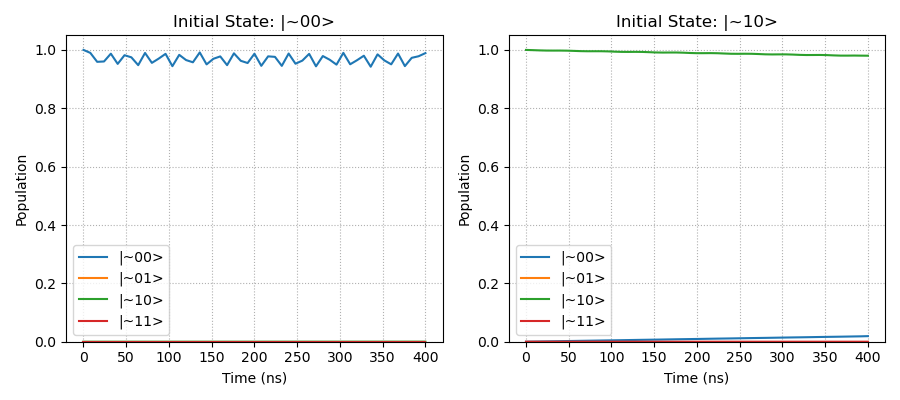

In [140]:
from qutip import parallel_map
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Parameters Tuned for Speed ---
t_r = 5
t_g = 400
t_list = np.linspace(0, t_g, 51)
alpha = 25

# --- INCREASE nsteps TO IMPROVE SOLVER ACCURACY ---
options = qt.Options(nsteps=10000) # Increased from 2500 to 10000

# --- Hamiltonian and Argument setup (no changes) ---
def eta(EF, EFT, ET, nF, nT):
    numerator = EF * nF + EFT * nT
    denominator = ET * nT
    return - numerator / denominator
eta = np.real(eta(EF, EFT, ET, nF_00_01, nT_00_01))
H_tot = [H_full, [alpha * (EF * n_Fl1_full + EFT * n_Tr_full + eta * ET * n_Tr_full), time_dep]]
args = {'t_g': t_g, 'w_d' : w_d, 't_r': t_r}

# --- Probability function for density matrices (no changes) ---
def prob_lists_mesolve(rho_list):
    projectors = [qt.ket2dm(dressed_epairs[i // 2, i % 2][1]) for i in range(4)]
    p_lists = [[qt.expect(proj, rho_t) for rho_t in rho_list] for proj in projectors]
    return p_lists

# --- Worker function for a single parallel simulation run (no changes) ---
def run_single_simulation(initial_ket, H, t_points, c_ops, solver_args, opts):
    rho0 = qt.ket2dm(initial_ket)
    result = qt.mesolve(H, rho0, t_points, c_ops=c_ops, args=solver_args, options=opts)
    return prob_lists_mesolve(result.states)

# --- Main function that uses parallel_map and then plots (no changes) ---
def run_and_plot_parallel():
    initial_states_kets = [
        dressed_epairs[0, 0][1],  # |~00>
        dressed_epairs[1, 0][1],  # |~10>
    ]

    task_args = (H_tot, t_list, c_ops_list, args, options)

    print("Starting parallel simulation for 2 initial states...")
    all_p_lists = parallel_map(run_single_simulation, initial_states_kets, task_args=task_args)
    print("Simulations finished.")

    # --- Plot the results in a 1x2 grid ---
    fig, axs = plt.subplots(1, 2, figsize=(9, 4))
    axs = axs.flatten()
    
    plot_titles = ["Initial State: |~00>", "Initial State: |~10>"]

    for i, p_lists in enumerate(all_p_lists):
        for j, p_list in enumerate(p_lists):
            label = "|~" + str(j // 2) + str(j % 2) + ">"
            axs[i].plot(t_list, p_list, label=label)
        axs[i].set_ylim(0, 1.05)
        axs[i].legend()
        axs[i].set_xlabel("Time (ns)")
        axs[i].set_ylabel("Population")
        axs[i].set_title(plot_titles[i])
        axs[i].grid(True, ls=':')

    plt.tight_layout()
    plt.show()

# --- Run the parallel simulation ---
run_and_plot_parallel()

In [80]:
from qutip import parallel_map

In [76]:
import qutip
print(qutip.__version__)

5.1.1
